In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from tensorflow.keras.layers import Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral

In [2]:
!pip install spectral



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 10.7 MB/s eta 0:00:00


In [14]:
# import numpy as np
# from collections import Counter
# from sklearn.model_selection import train_test_split
# import scipy.io as sio

# # Load dataset
# def load_data(name):
#     if name == 'IP':
#         data = sio.loadmat('/kaggle/input/dataip/Indian_pines_corrected.mat')['indian_pines_corrected']
#         labels = sio.loadmat('/kaggle/input/dataip/Indian_pines_gt.mat')['indian_pines_gt']
#     return data, labels

# # Process data: Flatten and split into train/test
# def preprocess_and_split(data, labels, test_size=0.3, random_state=42):
#     height, width, bands = data.shape
#     data_flat = data.reshape(-1, bands)  # Flatten to (pixels, bands)
#     labels_flat = labels.flatten()  # Flatten labels

#     # Keep only labeled pixels (remove background where label = 0)
#     labeled_indices = np.where(labels_flat > 0)
#     data_labeled = data_flat[labeled_indices]
#     labels_labeled = labels_flat[labeled_indices]

#     # Split train/test (Stratified to keep class distribution)
#     X_train, X_test, y_train, y_test = train_test_split(
#         data_labeled, labels_labeled, test_size=test_size, stratify=labels_labeled, random_state=random_state
#     )

#     return X_train, X_test, y_train, y_test, height, width, bands

# # Load and preprocess data
# data, labels = load_data('IP')
# X_train, X_test, y_train, y_test, height, width, bands = preprocess_and_split(data, labels)

# # Print Dataset Information
# print(f"Original Data Shape: {data.shape}")  # (height, width, bands)
# print(f"Labels Shape: {labels.shape}")  # (height, width)
# print(f"Train Data Shape: {X_train.shape}")  # (num_samples, bands)
# print(f"Test Data Shape: {X_test.shape}")  # (num_samples, bands)
# print(f"Train Labels Shape: {y_train.shape}")  
# print(f"Test Labels Shape: {y_test.shape}")  
# print(f"Total Number of Spectral Bands: {bands}")  

# # Count images per class
# train_class_counts = Counter(y_train)
# test_class_counts = Counter(y_test)

# print("\nNumber of images per class in training data:")
# for cls, count in sorted(train_class_counts.items()):
#     print(f"Class {cls}: {count} images")

# print("\nNumber of images per class in testing data:")
# for cls, count in sorted(test_class_counts.items()):
#     print(f"Class {cls}: {count} images")


In [4]:
def load_data(name):
    if name == 'IP':
        # Update the file paths to Kaggle's dataset path
        data = sio.loadmat('/kaggle/input/dataip/Indian_pines_corrected.mat')['indian_pines_corrected']
        labels = sio.loadmat('/kaggle/input/dataip/Indian_pines_gt.mat')['indian_pines_gt']  
    return data, labels

In [5]:
dataset = 'IP'
test_ratio = 0.7
windowSize = 25

In [6]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [7]:


def applyPCA(X, numComponents=75):
    # Print original dataset shape
    print(f"Original Data Shape: {X.shape}")  # (height, width, bands)
    
    # Reshape the data to 2D (pixels, bands)
    newX = np.reshape(X, (-1, X.shape[2]))
    
    # Apply PCA
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    
    # Reshape back to 3D (height, width, numComponents)
    newX = np.reshape(newX, (X.shape[0], X.shape[1], numComponents))
    
    # Print new data shape after PCA
    print(f"Data Shape After PCA: {newX.shape}")  # (height, width, numComponents)
    
    return newX, pca


In [8]:
# def padWithZeros(X, margin=2):
#     newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
#     x_offset = margin
#     y_offset = margin
#     newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
#     return newX

In [9]:
# def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
#     margin = int((windowSize - 1) / 2)
#     zeroPaddedX = padWithZeros(X, margin=margin)
#     # split patches
#     patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
#     patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
#     patchIndex = 0
#     for r in range(margin, zeroPaddedX.shape[0] - margin):
#         for c in range(margin, zeroPaddedX.shape[1] - margin):
#             patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
#             patchesData[patchIndex, :, :, :] = patch
#             patchesLabels[patchIndex] = y[r-margin, c-margin]
#             patchIndex = patchIndex + 1
#     if removeZeroLabels:
#         patchesData = patchesData[patchesLabels>0,:,:,:]
#         patchesLabels = patchesLabels[patchesLabels>0]
#         patchesLabels -= 1
#     return patchesData, patchesLabels

In [10]:
import numpy as np

# Function to pad the image with zeros
def padWithZeros(X, margin=2):
    print(f"Original Data Shape Before Padding: {X.shape}")  # Print original shape
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2 * margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    print(f"Data Shape After Padding: {newX.shape}")  # Print new shape after padding
    return newX

# Function to create image cubes (patches)
def createImageCubes(X, y, windowSize=5, removeZeroLabels=True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)

    # Initialize patch storage
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex += 1

    print(f"Total Patches Extracted: {patchIndex}")  # Total patches before filtering
    
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels > 0, :, :, :]
        patchesLabels = patchesLabels[patchesLabels > 0]
        patchesLabels -= 1  # Adjust labels to start from 0

    print(f"Patch Data Shape After Removing Zero Labels: {patchesData.shape}")
    print(f"Patch Labels Shape After Removing Zero Labels: {patchesLabels.shape}")
    
    return patchesData, patchesLabels


In [11]:
X, y = load_data(dataset)

X.shape, y.shape

((145, 145, 200), (145, 145))

In [12]:
K = X.shape[2]

In [13]:
K = 30
X,pca = applyPCA(X,numComponents=K)

X.shape

Original Data Shape: (145, 145, 200)
Data Shape After PCA: (145, 145, 30)


(145, 145, 30)

In [14]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

Original Data Shape Before Padding: (145, 145, 30)
Data Shape After Padding: (169, 169, 30)
Total Patches Extracted: 21025
Patch Data Shape After Removing Zero Labels: (10249, 25, 25, 30)
Patch Labels Shape After Removing Zero Labels: (10249,)


((10249, 25, 25, 30), (10249,))

In [15]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((3074, 25, 25, 30), (7175, 25, 25, 30), (3074,), (7175,))

In [16]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(3074, 25, 25, 30, 1)

In [17]:
from tensorflow.keras.utils import to_categorical
ytrain = to_categorical(ytrain)

In [18]:
ytrain.shape

(3074, 16)

In [19]:
S = windowSize
L = K
output_units = 9 

In [20]:
## input layer
input_layer = Input((25, 25, 30, 1))  # Adjust input shape based on your data

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)

# Reshaping to match the expected dimensions
conv3d_shape = conv_layer3.shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3] * conv3d_shape[4]))(conv_layer3)

conv_layer4 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(conv_layer3)

flatten_layer = Flatten()(conv_layer4)

## fully connected layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=16, activation='softmax')(dense_layer2)


In [21]:
model = Model(inputs=input_layer, outputs=output_layer)

In [22]:

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 25, 25, 30, 1)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d (Conv3D)                      │ (None, 23, 23, 24, 8)       │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 21, 21, 20, 16)      │           5,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 19, 19, 18, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 19, 19, 576)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 17, 17, 64)          │         331,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18496)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       4,735,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │           2,064 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,122,176 (19.54 MB)

 Trainable params: 5,122,176 (19.54 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Define the learning rate schedule
learning_rate_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

# Use the learning rate schedule in the Adam optimizer
adam = Adam(learning_rate=learning_rate_schedule)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Checkpoint configuration
filepath = "best-model.keras" 
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# List of callbacks
callbacks_list = [checkpoint]


In [25]:

history = model.fit(
    x=Xtrain, 
    y=ytrain, 
    batch_size=256, 
    epochs=50, 
    callbacks=callbacks_list, 
    validation_split=0.2,  # Optionally, use validation data split
    shuffle=True  # To shuffle the dataset at the start of each epoch
)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 951ms/step - accuracy: 0.1392 - loss: 2.6926
Epoch 1: val_accuracy improved from -inf to 0.23902, saving model to best-model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.1422 - loss: 2.6849 - val_accuracy: 0.2390 - val_loss: 2.3798
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.2159 - loss: 2.3823
Epoch 2: val_accuracy improved from 0.23902 to 0.45366, saving model to best-model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 0.2171 - loss: 2.3767 - val_accuracy: 0.4537 - val_loss: 1.9534
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.3839 - loss: 1.8908
Epoch 3: val_accuracy improved from 0.45366 to 0.62927, saving model to best-model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - accuracy: 0.3887 - loss: 1.8751 - val_accuracy: 0.6293 - val_loss: 1.0664
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.6001 - loss: 1.2059
Epoch 4: val_accuracy improved from 0.62927

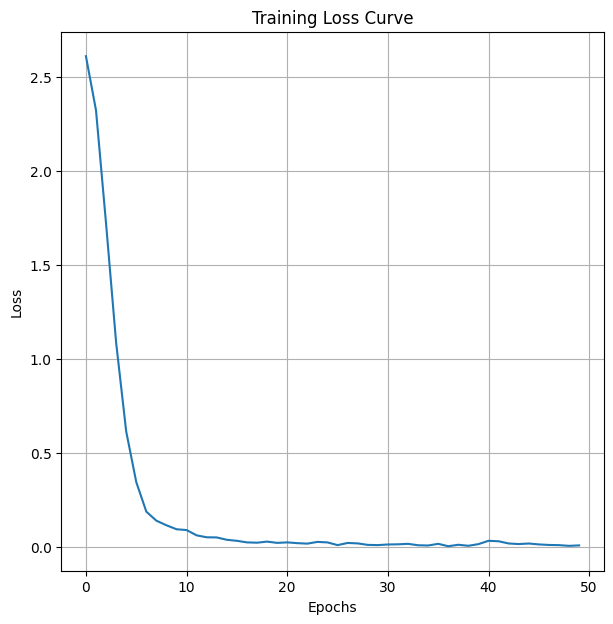

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))  # Create figure with size 7x7
plt.grid()                 # Enable grid
plt.plot(history.history['loss'])  # Plot loss curve
plt.xlabel('Epochs')        # Label for x-axis
plt.ylabel('Loss')          # Label for y-axis
plt.title('Training Loss Curve')  # Title of the plot
plt.show()  # Display the plot


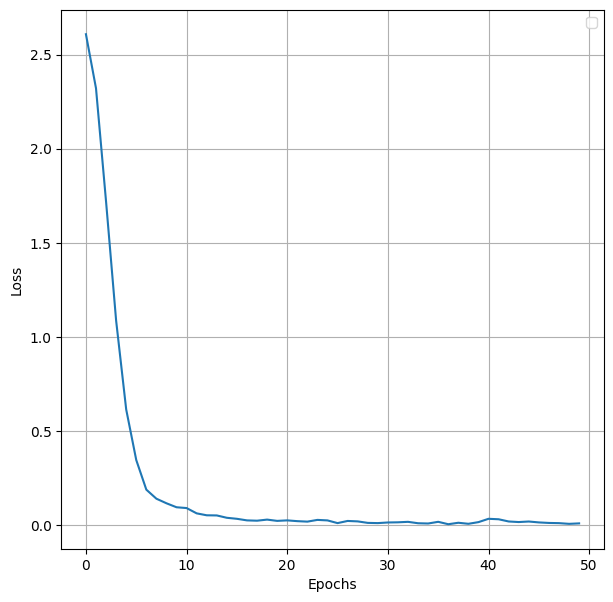

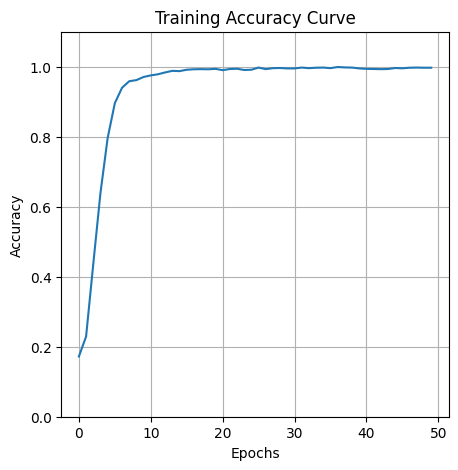

In [27]:
import matplotlib.pyplot as plt

# Loss Curve
plt.figure(figsize=(7,7))  
plt.ylabel('Loss')  
plt.xlabel('Epochs')  
plt.legend(['Training', 'Validation'], loc='upper right')  
plt.grid()  
plt.plot(history.history['loss'])  
plt.savefig("loss_curve.pdf")  
plt.show()  

# Accuracy Curve
plt.figure(figsize=(5,5))  
plt.ylim(0,1.1)  
plt.grid()  
plt.plot(history.history['accuracy'])  
plt.xlabel('Epochs')  
plt.ylabel('Accuracy')  
plt.title('Training Accuracy Curve')  
plt.show()


In [28]:
from tensorflow.keras.models import load_model

# Load the best saved model
model = load_model("best-model.keras")



In [29]:
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [30]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(7175, 25, 25, 30, 1)

In [31]:
ytest = to_categorical(ytest)
print(ytest.shape)

(7175, 16)


In [32]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        32
           1       0.99      1.00      0.99      1000
           2       1.00      0.98      0.99       581
           3       0.99      1.00      1.00       166
           4       0.99      1.00      1.00       338
           5       0.98      1.00      0.99       511
           6       1.00      0.80      0.89        20
           7       1.00      1.00      1.00       335
           8       1.00      1.00      1.00        14
           9       0.99      0.99      0.99       680
          10       1.00      0.99      1.00      1719
          11       1.00      0.98      0.99       415
          12       0.96      1.00      0.98       143
          13       1.00      1.00      1.00       886
          14       1.00      0.99      0.99       270
          15       0.98      0.98      0.98        65

    accuracy                           

In [33]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [34]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
   
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [35]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9933 - loss: 0.0178


In [36]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [37]:
def load_data(name):
    if name == 'IP':
        # Update the file paths to Kaggle's dataset path
        data = sio.loadmat('/kaggle/input/dataip/Indian_pines_corrected.mat')['indian_pines_corrected']
        labels = sio.loadmat('/kaggle/input/dataip/Indian_pines_gt.mat')['indian_pines_gt']  
    return data, labels

In [38]:
# load the original image
X, y = load_data(dataset)

In [39]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [40]:
X,pca = applyPCA(X, numComponents=numComponents)

Original Data Shape: (145, 145, 200)
Data Shape After PCA: (145, 145, 30)


In [41]:
X = padWithZeros(X, PATCH_SIZE//2)

Original Data Shape Before Padding: (145, 145, 30)
Data Shape After Padding: (169, 169, 30)


In [ ]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


<ipython-input-42-aa7351b057d0>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  outputs[i][j] = prediction+1


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

In [ ]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

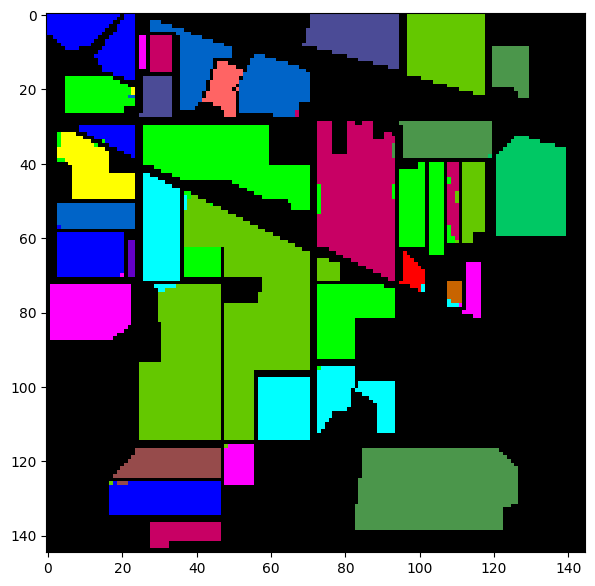

In [44]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

In [45]:
spectral.save_rgb("predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)